# Machine learning using EKF

In [1]:
from IPython import display
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

# Importing Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Select data directory
print("Current Directory:",os.getcwd())
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('..\data/'):
    course_data_dir = '..\data'
else:
    # Specify course_data_dir on your machine
    # course_data_dir = ...
    # YOUR CODE HERE
    raise NotImplementedError()

print('The data directory is %s' % course_data_dir)

Current Directory: D:\Projects\NLP_Project\NeuralNetworkswKalmanFilters\src
The data directory is ..\data


In [3]:
# Select device which you are going to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_dtype(torch.float32)

cuda:0


### Import Data Sets
Testing using a toy sine data

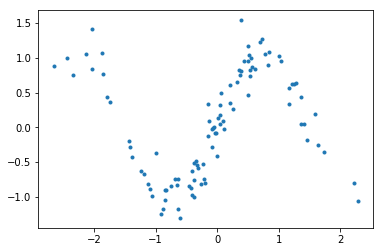

In [4]:
# Let us generate toy data
np.random.seed(2)
x_train = np.random.randn(100, 1)
x_train = np.sort(x_train, axis=0)
y_train = np.sin(x_train * 2 * np.pi / 3)
y_train = y_train + 0.2 * np.random.randn(*y_train.shape)

# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x_train, y_train, '.')

## Data Preprocessing


In [5]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

## Define Neural network

In [6]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden_layer, n_outputs,bias=True):
        super(MLP, self).__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.fc1 = nn.Linear(n_inputs, n_hidden_layer, bias)
        self.fc2 = nn.Linear(n_hidden_layer, n_hidden_layer, bias)
        self.fc3 = nn.Linear(n_hidden_layer, n_outputs, bias)
        

    def forward(self, x):
        # YOUR CODE HERE
        #raise NotImplementedError()
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x    

In [7]:
## Testing net
n_inputs = 1
n_outputs = 1
n_hidden_layer = 100
test_net = MLP(n_inputs, n_hidden_layer, n_outputs)
print(test_net)

MLP(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


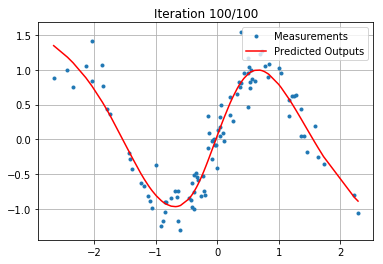

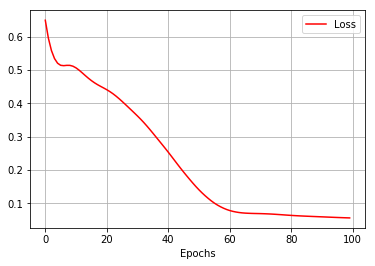

In [126]:
# Define number of Input and Output layers
n_inputs = 1
n_outputs = 1
n_hidden_layer = 20
mlp = MLP(n_inputs,n_hidden_layer, n_outputs)
mpl = mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.005)
n_epochs = 100

train_accuracy_history = []
test_accuracy_history = []

x_train = torch.tensor(x_train, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train, device=device, dtype=torch.float32)

ceLoss = nn.MSELoss()

# Plotting before learning 
fig, ax = plt.subplots(1)
fig_loss, ax_loss = plt.subplots(1)
ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), '.')
loss_all = []
epoch_all = []
for epoch in range(n_epochs):
    
    #Set gradients as zero
    mlp.zero_grad()
    #Calculate outputs with forward()
    #print(x_train)
    outputs = mlp(x_train)   
    
    #calculate loss
    loss = ceLoss(outputs, y_train)
    #calculate gradients - calling backward()
    loss.backward()
    
    #update weights using optimizer
    optimizer.step()
 
    ax.clear()
    plt_x_train = x_train.cpu().detach().numpy()
    plt_y_train = y_train.cpu().detach().numpy()
    plt_outputs = outputs.cpu().detach().numpy()
    ax.plot(plt_x_train, plt_y_train, '.',label='Measurements')
    ax.plot(plt_x_train, plt_outputs, 'r-',label='Predicted Outputs')
    ax.legend(loc = 1)
    ax.grid(True)
    ax.set_title('Iteration %d/%d' % (epoch+1, n_epochs))
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.005)
    
    loss_all.append(loss)
    epoch_all.append(epoch)
display.clear_output(wait=True)
ax_loss.plot(epoch_all,loss_all, 'r-',label='Loss')
ax_loss.grid(True)
ax_loss.legend(loc = 1)
plt.xlabel('Epochs')


## Using EKF for learning 

In [130]:
# #Calculate Weight size
# weight_mat_size = 0
# for i in range(len(layer_list)-1):
#     weight_mat_size = weight_mat_size + (layer_list[i]*layer_list[i+1])
        
def getWeights(net):
    weight_mat = []
    for name,param in net.named_parameters():
    
        #print('Layer',name, 'is', param.data.shape)
        if (len(list(param.data.shape)) == 2):
            weight_mat.append(param.data.flatten())
        
    weight_mat = torch.cat(weight_mat, dim=0)       
    #print('Shape of weight matrix', weight_mat.shape)
    return weight_mat.view(-1, 1)

def getWeightsgrad(net):
    weight_grad_mat = []
    for name,param in net.named_parameters():
    
        #print('Layer Grads',name, 'is', param.grad.shape)
        if (len(list(param.grad.shape)) == 2):
            weight_grad_mat.append(param.grad.flatten())
        
    weight_grad_mat = torch.cat(weight_grad_mat, dim=0)       
    #print('Shape of weight matrix', weight_grad_mat.shape)   
    return weight_grad_mat.view(-1, 1)

def setWeights(net, weight_mat):
    mem_ind = 0;
    for name,param in net.named_parameters():
        if (len(list(param.data.shape)) == 2):
            #print('Layer',name, 'is', param.data.shape)
            #print(torch.numel(param.data))
            #print(weight_mat[mem_ind:mem_ind+torch.numel(param.data)].view(param.data.shape).shape)
            param.data = weight_mat[mem_ind:mem_ind+torch.numel(param.data)].view(param.data.shape)
            mem_ind = torch.numel(param.data)
    
def L1ErrorSigned(outputs,labels):
    
    return (labels-outputs)    


In [135]:
torch.set_default_dtype(torch.float32)

# Define number of Input and Output layers, Batch size
n_inputs = 1
n_hidden_layer = 20
n_outputs = 1
batch_size = 1
mlp_EKF = MLP(n_inputs,n_hidden_layer, n_outputs, bias = False)
mlp_EKF = mlp_EKF.to(device)
n_epochs = 20

print("Printing network",mlp_EKF)

# Define EKF covariances
# System Noise or also known as training  noise  
Q = 1e-6*torch.eye((getWeights(mlp_EKF).shape[0]),device=device)
# Measurement noise or noise in targets / Learning rate
R = 50*torch.eye(batch_size*n_outputs,device=device)
#Covariance Matrix
P = 100*torch.eye((getWeights(mlp_EKF).shape[0]),device=device)

#n = getWeights(mlp_EKF).shape[0]



Printing network MLP(
  (fc1): Linear(in_features=1, out_features=20, bias=False)
  (fc2): Linear(in_features=20, out_features=20, bias=False)
  (fc3): Linear(in_features=20, out_features=1, bias=False)
)


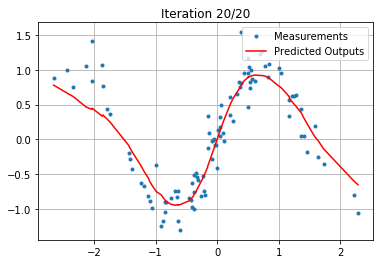

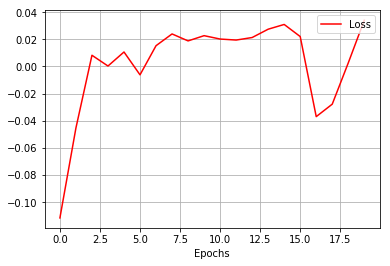

In [136]:
x_train = torch.tensor(x_train, device=device)
y_train = torch.tensor(y_train, device=device)

lossFcn = L1ErrorSigned

# Plotting before learning 
fig, ax = plt.subplots(1)
fig_loss, ax_loss = plt.subplots(1)
ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), '.')

loss_all = []
epoch_all = []
loss_running = 0

for epoch in range(n_epochs):
    
    outputs = [] 
    #Calling Backward for each sample
    loss_running = 0
    for i in range((x_train.shape[0])):
        
        output = mlp_EKF(x_train[i])
        outputs.append(output)
        mlp_EKF.zero_grad()
        #calculate gradients - calling backward()
        output.backward()
        #Calculate loss
        loss = lossFcn(output, y_train[i,-1]).view(1,-1)
        loss_running = loss_running + loss
        # EKF Equations
        H = getWeightsgrad(mlp_EKF).to(device).view(1,-1)
        Ak = torch.inverse(R + torch.mm(torch.mm(H, P), torch.transpose(H,0,1)))
        Kk = torch.mm(torch.mm(P, torch.transpose(H,0,1)), Ak)
        #Update Weights
        weight_mat= getWeights(mlp_EKF).to(device)
        weight_mat = weight_mat + torch.mm(Kk, loss)
        setWeights(mlp_EKF,weight_mat)
        P = P + Q - torch.mm(torch.mm(Kk,H),P)
        
    loss_running = loss_running/x_train.shape[0] 
    #Create predicted outputs
    outputs = torch.cat(outputs, dim=0)
    loss_all.append(loss_running)
    epoch_all.append(epoch)
    #Plotting Output
    ax.clear()
    plt_x_train = x_train.cpu().detach().numpy()
    plt_y_train = y_train.cpu().detach().numpy()
    plt_outputs = outputs.cpu().detach().numpy()
    ax.plot(plt_x_train, plt_y_train, '.',label='Measurements')
    ax.plot(plt_x_train, plt_outputs, 'r-',label='Predicted Outputs')
    ax.grid(True)
    ax.set_title('Iteration %d/%d' % (epoch+1, n_epochs))
    ax.legend(loc=1)
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.005)
    
display.clear_output(wait=True)

ax_loss.plot(epoch_all,loss_all, 'r-',label='Loss')
ax_loss.grid(True)
ax_loss.legend(loc = 1)
plt.xlabel('Epochs')


In [66]:
def set_sigma_points(m, P, lambda_ukf, n):
    out = torch.zeros(n,2*n+1,device=device) 
    out[:,1] = m.view(-1)
    indices = list(range(n))*2
    #print(P[0,0])
    #print(P)
    L = torch.cholesky(P)
    for i in range(n):
        out[:,indices[i]] = m.view(-1) + torch.mul(L[:,i],torch.sqrt(torch.tensor(n,dtype=torch.float32) + lambda_ukf));
        out[:,indices[i]+1] = m.view(-1) - torch.mul(L[:,i],torch.sqrt(torch.tensor(n,dtype=torch.float32) + lambda_ukf));
        
    return out

def calculate_mean(W0, Wi, xhat):
    n = xhat.shape[1]
    mean = W0*xhat[:,0]
    for i in range(1,n):
        mean = mean + (Wi*xhat[:,i])
    return mean

def calculate_covariance(W0, Wi, xhat, mx, yhat, my, verbose = False):
    n = xhat.shape[1]
    covariance = W0*((xhat[:,0] - mx).view(-1,1))*torch.transpose((yhat[:,0] - my).view(-1,1),0,1)
    if verbose is True: print("Shape of Cov Mat", covariance.shape)
    for i in range(1,n):
        covariance = covariance + Wi*((xhat[:,i] - mx).view(-1,1))*torch.transpose((yhat[:,i] - my).view(-1,1),0,1)
    if verbose is True: print("Shape of Cov Mat", covariance.shape)
    return covariance

In [109]:
torch.set_default_dtype(torch.float32)

# Define number of Input and Output layers, Batch size
n_inputs = 1
n_hidden_layer = 20
n_outputs = 1
batch_size = 1
mlp_UKF = MLP(n_inputs,n_hidden_layer, n_outputs, bias = False)
mlp_UKF = mlp_UKF.to(device)
n_epochs = 10

print("Printing network",mlp_UKF)

# Define EKF covariances
# System Noise or also known as training  noise  
Q = 1e-6*torch.eye((getWeights(mlp_UKF).shape[0]),device=device)
# Measurement noise or noise in targets / Learning rate
R = 50*torch.eye(batch_size*n_outputs,device=device)

#UKF Design
n_weights = getWeights(mlp_UKF).shape[0]

alpha_ukf = 1
kappa_ukf = 1
beta_ukf  = 1

lambda_ukf = alpha_ukf^2*(n_weights + kappa_ukf) - n_weights

# Calculate UKF Weights
W0m = lambda_ukf/(n_weights+lambda_ukf);
Wim = 1/(2*(n_weights+lambda_ukf));

W0c = (lambda_ukf/(n_weights + lambda_ukf))+(1 - (alpha_ukf^2) + beta_ukf);
Wic = Wim;

# storage for sigma points
nsp = (2*n_weights)+1;

xsp = torch.zeros(n_weights,nsp,device=device);
xsu = torch.zeros(n_weights,nsp,device=device);

# storage for xhat and yhat
xhat = torch.zeros(n_weights,nsp,device=device);
yhat = torch.zeros(1,nsp,device=device);

#Initialize means and covariance
mf = W0m*getWeights(mlp_UKF)
Pf = 100*torch.eye((getWeights(mlp_UKF).shape[0]),device=device)
#print(Pm)


Printing network MLP(
  (fc1): Linear(in_features=1, out_features=20, bias=False)
  (fc2): Linear(in_features=20, out_features=20, bias=False)
  (fc3): Linear(in_features=20, out_features=1, bias=False)
)


C:\Users\jiyoj\AppData\Local\conda\conda\envs\dle\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
C:\Users\jiyoj\AppData\Local\conda\conda\envs\dle\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor(100., device='cuda:0')
Pm tensor(150.4534, device='cuda:0')
Sub Term tensor(1142.0811, device='cuda:0')
tensor(-991.6277, device='cuda:0')


RuntimeError: MAGMA potrf : A(1,1) is 0, A cannot be factorized at c:\a\w\1\s\tmp_conda_3.6_091443\conda\conda-bld\pytorch_1544087948354\work\aten\src\thc\generic/THCTensorMathMagma.cu:602

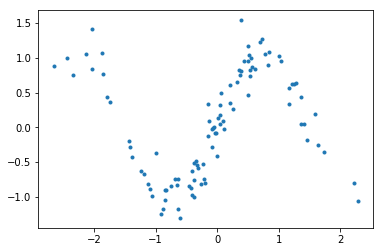

In [110]:
x_train = torch.tensor(x_train, device=device,dtype=torch.float32)
y_train = torch.tensor(y_train, device=device,dtype=torch.float32)

lossFcn = L1ErrorSigned

# Plotting before learning 
fig, ax = plt.subplots(1)
ax.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), '.')

with torch.no_grad():
    for epoch in range(n_epochs):

        outputs = [] 
        #Calling Backward for each sample
        for i in range((x_train.shape[0])):

            #print(x_train[i])
            # UKF Equations
            xsp = set_sigma_points(mf,Pf,lambda_ukf,n_weights)
            mm = calculate_mean(W0m, Wim, xsp)
            #print("Shape of mm",mm.shape)
            Pm = calculate_covariance(W0c, Wic, xsp, mm, xsp, mm)
            #print(Pm)
            Pm = Pm + Q

            xsu = set_sigma_points(mm,Pm,lambda_ukf,n_weights)

            # propagate through measurement model
            for j in range(nsp):
                setWeights(mlp_UKF, xsu[:,j])
                yhat[:,j] = mlp_UKF(x_train[i])
    #         outputs.append(output)

            mu = calculate_mean(W0m,Wim,yhat)
            S = calculate_covariance(W0c,Wic,yhat,mu,yhat,mu,False)
            #print("S Mat",S)
            S = S + R
            C = calculate_covariance(W0c,Wic,xsu, mm, yhat, mu,False)
            #print("C Mat",C)
            Kk = C*torch.inverse(S)

            #Calculate loss
            loss = lossFcn(mu, y_train[i,-1]).view(1,-1)
            #Update Weights
            #print("Shape of mm",mm.shape)
            #print("shape of matmul", torch.mm(Kk, loss).shape)
            #print("Pf",Pf[0][0])
            mm = mm + torch.mm(Kk,loss)
            diff = torch.mm(torch.mm(Kk,S),torch.transpose(Kk,0,1))
            print(Pf[0][0])
            print("Pm",Pm[0][0])
            print("Sub Term",(torch.mm(torch.mm(Kk,S),torch.transpose(Kk,0,1)))[0][0])
            Pf = Pm - torch.mm(torch.mm(Kk,S),torch.transpose(Kk,0,1))
            print(Pf[0][0])
            

            #print("Shape of mm",mm.shape)
    #         setWeights(mlp_UKF,mm)    
    #         #Create predicted outputs
    #         outputs =  mlp_UKF(x_train)


        setWeights(mlp_UKF,mm)    
        #Create predicted outputs
        outputs =  mlp_UKF(x_train)

        #Plotting Output
        ax.clear()
        plt_x_train = x_train.cpu().detach().numpy()
        plt_y_train = y_train.cpu().detach().numpy()
        plt_outputs = outputs.cpu().detach().numpy()
        ax.plot(plt_x_train, plt_y_train, '.')
        ax.plot(plt_x_train, plt_outputs, 'r-')
        ax.grid(True)
        ax.set_title('Iteration %d/%d' % (epoch+1, n_epochs))
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.005)

    display.clear_output(wait=True)

# Appendix